### Get Transition Probabilities

In [13]:
from collections import defaultdict
from itertools import product, combinations, chain
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
# same action and same state success or failure amy lead to the same next state, we aggeragert data

In [14]:
def getPossibleStates(edges, max_age):
    """
    Returns: list of states, where each state is a tuple of ((edge), age)
    """
    sorted_edges = sorted(tuple(sorted(e)) for e in edges)
    possible_ages = [-1] + list(range(1, max_age + 1))

    all_states = [
        tuple(zip(sorted_edges, age_combo))
        for age_combo in product(possible_ages, repeat=len(sorted_edges))
    ]

    return all_states

def getAgedStates(state, maxAge):
    """
    Returns:
        New state as a tuple of ((edge), age) pairs
    """
    new_state = []
    for edge, age in state:
        if age == -1:
            new_state.append((edge, -1))  # not entangled
        else:
            new_age = age + 1
            if new_age <= maxAge:
                new_state.append((edge, new_age))
            else:
                new_state.append((edge, -1))  # entanglement expired

    return tuple(sorted(new_state))


def generateAllOutcomes(state, pGen):
    empty_edges = [edge for edge, age in state if age == -1]
    outcomes = []

    for pattern in product([0, 1], repeat=len(empty_edges)):
        prob = 1.0
        new_state = []

        # First, update the empty edges based on entanglement outcomes
        outcome_map = {}
        for (edge, outcome) in zip(empty_edges, pattern):
            if outcome:
                prob *= pGen
                outcome_map[edge] = 1
            else:
                prob *= (1 - pGen)
                outcome_map[edge] = -1

        # Now build the full new state
        for edge, age in state:
            if edge in outcome_map:
                new_state.append((edge, outcome_map[edge]))
            else:
                new_state.append((edge, age))  # unchanged

        outcomes.append((tuple(sorted(new_state)), prob))

    return outcomes

def generateAllSwappingOutcomes(state, goalEdges, pSwap):
    """
    Generate all possible outcomes from swapping operations or doing nothing.
    Can attempt multiple non-overlapping swaps simultaneously.
    """
    def find_path(current, target, visited):
        if current == target:
            return [current]
        visited.add(current)
        for next_node in graph.get(current, []):
            if next_node not in visited:
                path = find_path(next_node, target, visited)
                if path:
                    return [current] + path
        return None

    # First find all possible individual swap attempts
    swap_attempts = []
    entangled_edges = [(edge, age) for edge, age in state if age > 0]
    
    # Create graph once for all path finding
    graph = {}
    for (edge, _) in entangled_edges:
        if edge[0] not in graph: graph[edge[0]] = []
        if edge[1] not in graph: graph[edge[1]] = []
        graph[edge[0]].append(edge[1])
        graph[edge[1]].append(edge[0])
    
    # Find all possible paths for each goal
    for goal_edge in goalEdges:
        start, end = goal_edge
        path = find_path(start, end, set())
        
        if path and len(path) > 1:
            path_edges = list(zip(path[:-1], path[1:]))
            used_edges = []
            for p_edge in path_edges:
                for e, age in entangled_edges:
                    if (e[0] == p_edge[0] and e[1] == p_edge[1]) or \
                       (e[0] == p_edge[1] and e[1] == p_edge[0]):
                        used_edges.append((e, age))
            
            swap_attempts.append({
                'goal': goal_edge,
                'used_edges': used_edges,
                'num_swaps': len(path_edges) - 1
            })
    
    outcomes = []
    
    # Case 1: Do nothing
    outcomes.append((state, 1.0, None))
    
    # Case 2: Try all possible combinations of non-overlapping swaps
    for r in range(1, len(swap_attempts) + 1):
        for attempt_combo in combinations(swap_attempts, r):
            # Check if attempts are compatible (don't share edges)
            all_used_edges = set()
            edge_overlap = False
            for attempt in attempt_combo:
                attempt_edges = set(e for e, _ in attempt['used_edges'])
                if any(e in all_used_edges for e in attempt_edges):
                    edge_overlap = True
                    break
                all_used_edges.update(attempt_edges)
            
            if edge_overlap:
                continue
                
            # Generate all success/failure combinations for this set of attempts
            for success_pattern in product([True, False], repeat=len(attempt_combo)):
                new_state = []
                total_prob = 1.0
                achieved_goals = []
                
                # Calculate probability and track achieved goals
                for attempt, succeeded in zip(attempt_combo, success_pattern):
                    prob = pSwap ** attempt['num_swaps'] if succeeded else \
                          (1 - pSwap ** attempt['num_swaps'])
                    total_prob *= prob
                    if succeeded:
                        achieved_goals.append((attempt['goal'], True))
                    else:
                        achieved_goals.append((attempt['goal'], False))
                
                # Create new state
                for edge, age in state:
                    if any(edge == e for attempt in attempt_combo 
                          for e, _ in attempt['used_edges']):
                        new_state.append((edge, -1))  # Used edges become unentangled
                    else:
                        new_state.append((edge, age))  # Other edges remain unchanged
                
                new_state = tuple(sorted(new_state))
                outcomes.append((new_state, total_prob, achieved_goals))
    
    return outcomes


In [15]:
def getAllTransitionProbabilities(state, goalEdges, pSwap, pGen, maxAge):
    """
    Returns:
        List of (new_state, probability, achieved_goals) tuples
    """
    all_transitions = []
    
    # Get all possible swap action outcomes
    swap_outcomes = generateAllSwappingOutcomes(state, goalEdges, pSwap)
    
    # For each swap outcome, generate all possible generation outcomes
    for swap_state, swap_prob, achieved_goals in swap_outcomes:
        # Skip if swap probability is 0
        if swap_prob == 0:
            continue
            
        # First age the state
        aged_state = getAgedStates(swap_state, maxAge)
        
        # Then get all possible generation outcomes
        gen_outcomes = generateAllOutcomes(aged_state, pGen)
        
        # Combine the probabilities and add to transitions
        for final_state, gen_prob in gen_outcomes:
            # Skip if either probability is 0
            if gen_prob == 0:
                continue
                
            all_transitions.append((
                final_state,
                swap_prob * gen_prob,
                achieved_goals
            ))
    
    return all_transitions

def generateAllStateTransitions(edges, goalEdges, pSwap, pGen, maxAge):
    """
    Returns:
        Dictionary mapping state -> list of (next_state, prob, achieved_goals)
    """
    # Get all possible states
    all_states = getPossibleStates(edges, maxAge)
    transitions = {}
    
    # For each state, calculate all possible transitions
    for state in all_states:
        transitions[state] = getAllTransitionProbabilities(state, goalEdges, pSwap, pGen, maxAge)
    
    return transitions

### Value Iteration


In [16]:
# Test the function
edges = [(0, 1), (1, 2)]
goalEdges = [(0, 2)]
pSwap = 0.99
pGen = 0.99
maxAge = 2

# Value iteration parameters
gamma = 0.95
epsilon = 0.001
max_iterations = 1000
initial_state = tuple((edge, -1) for edge in edges) # For iteration / simulation

all_transitions = generateAllStateTransitions(edges, goalEdges, pSwap, pGen, maxAge)   



Converged after 47 iterations


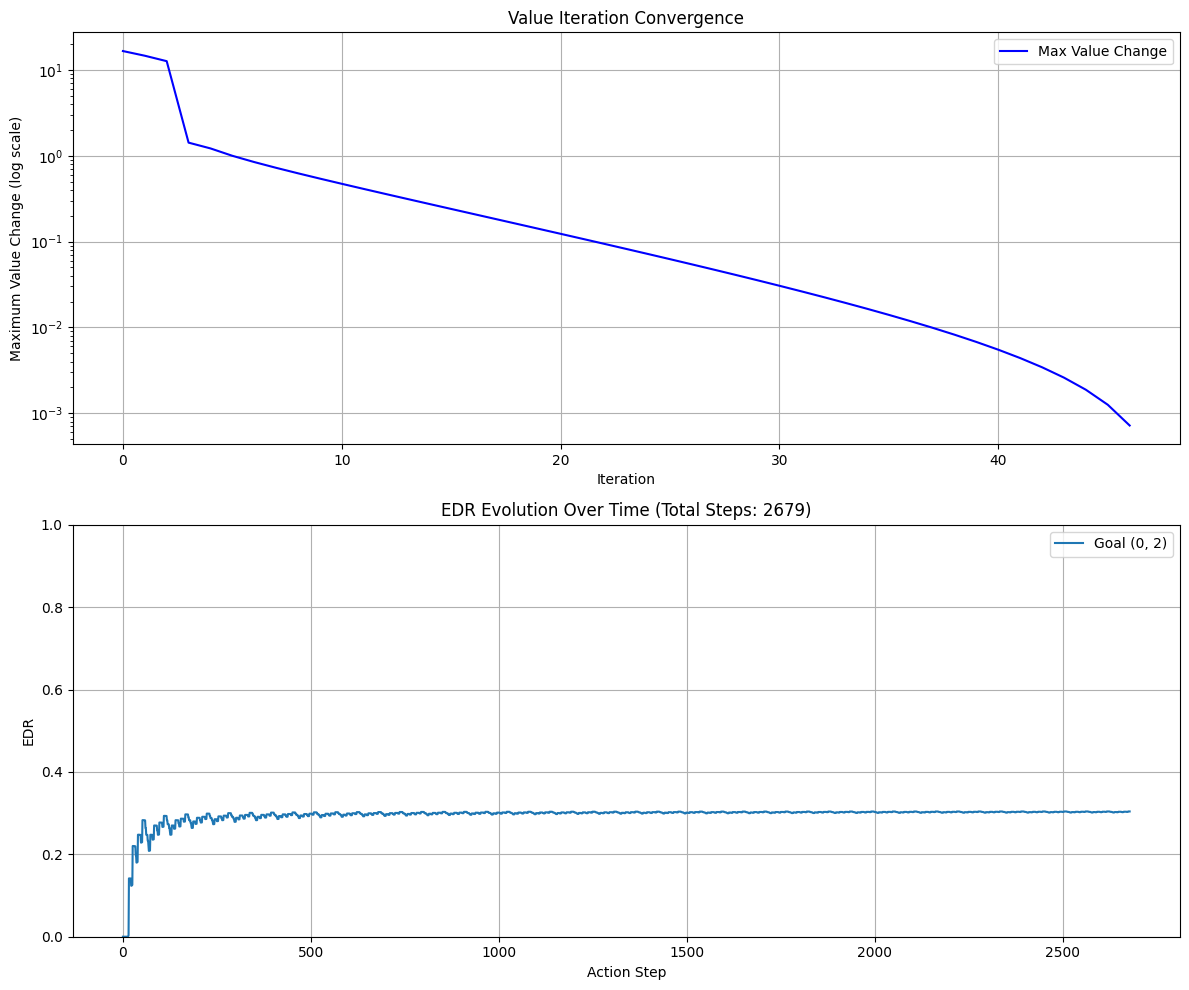

0.99 0.99 2 [(0, 1), (1, 2)] [(0, 2)]

=== Final EDR Statistics ===
Goal (0, 2): EDR = 0.304118
  - Successes: 186.12
  - Total timesteps: 612.00
Total number of EDR data points: 2679


In [17]:
from collections import defaultdict
import matplotlib.pyplot as plt
import math

def getImmediateReward(achieved_goals, goal_success_counts, total_timesteps):
    if achieved_goals is None:
        return 0
    
    total_reward = 0
    for goal_edge, success in achieved_goals:
        if success:
            # For each goal, we need one swap per intermediate node in the path
            # This is encoded in the transitions - if a goal succeeds, it means
            # we used the shortest path to achieve it
            start, end = goal_edge
            # Minimum number of swaps needed is the number of intermediate nodes
            # in the shortest path between start and end
            num_edges = abs(end - start)  # This gives us number of edges in path
            instant_rate = pSwap ** (num_edges - 1)  # -1 because num_swaps = num_edges - 1
            
            # Calculate average rate (EDR) with minimum threshold
            edr = max(0.0001, goal_success_counts[goal_edge] / max(1, total_timesteps))
            
            # Add log of the ratio to total reward
            if instant_rate > 0 and edr > 0:
                total_reward += instant_rate / edr
                if total_reward < 0:
                    print('AHHHHHH')

    return total_reward


# Initialize value function and EDR tracking
values = {state: 0 for state in all_transitions.keys()}
policy = {state: None for state in all_transitions.keys()}
convergence_data = []

# Global tracking variables
total_timesteps = 1
goal_success_counts = {goal: 0 for goal in goalEdges}
edr_history = {goal: [] for goal in goalEdges}

# Value iteration parameters
gamma = 0.9
epsilon = 0.001
max_iterations = 1000

# Create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Run value iteration
for iteration in range(max_iterations):
    delta = 0
    new_values = values.copy()
    
    # Update value for each state
    for state in all_transitions.keys():
        action_values = defaultdict(float)
        
        for next_state, prob, achieved_goals in all_transitions[state]:
            # Simulate timestep for EDR tracking
            total_timesteps += prob
            
            # Update EDR tracking for this specific transition
            if achieved_goals is not None:
                for goal_edge, success in achieved_goals:
                    if success:
                        goal_success_counts[goal_edge] += prob
            
            # Calculate reward using current EDR values
            immediate_reward = getImmediateReward(achieved_goals, goal_success_counts, total_timesteps)
            future_value = gamma * values[next_state]
            action_values[str(achieved_goals)] += prob * (immediate_reward + future_value)
            
            # Update EDR history after each transition
            for goal in goalEdges:
                current_edr = goal_success_counts[goal] / total_timesteps
                edr_history[goal].append(current_edr)
        
        if action_values:
            best_action = max(action_values.items(), key=lambda x: x[1])
            new_values[state] = best_action[1]
            policy[state] = eval(best_action[0]) if best_action[0] != 'None' else None
            delta = max(delta, abs(new_values[state] - values[state]))
    
    # Update values
    values = new_values
    convergence_data.append(delta)
    
    # Check for convergence
    if delta < epsilon:
        print(f"Converged after {iteration + 1} iterations")
        break

# Plot convergence
ax1.plot(convergence_data, 'b-', label='Max Value Change')
ax1.set_yscale('log')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Maximum Value Change (log scale)')
ax1.set_title('Value Iteration Convergence')
ax1.grid(True)
ax1.legend()

# Plot EDR
for goal, edr_values in edr_history.items():
    ax2.plot(range(len(edr_values)), edr_values, label=f'Goal {goal}')
ax2.set_xlabel('Action Step')
ax2.set_ylabel('EDR')
ax2.set_title(f'EDR Evolution Over Time (Total Steps: {len(edr_history[goalEdges[0]])})')
ax2.grid(True)
ax2.legend()
ax2.set_ylim(0, 1)  # Set y-axis limits between 0 and 1

plt.tight_layout()
plt.show()

print(pSwap, pGen, maxAge, edges, goalEdges)
# Print final EDR statistics
print("\n=== Final EDR Statistics ===")
for goal in goalEdges:
    final_edr = goal_success_counts[goal] / total_timesteps
    print(f"Goal {goal}: EDR = {final_edr:.6f}")
    print(f"  - Successes: {goal_success_counts[goal]:.2f}")
    print(f"  - Total timesteps: {total_timesteps:.2f}")
print(f"Total number of EDR data points: {len(edr_history[goalEdges[0]])}")

### **Evaluate with EDR**

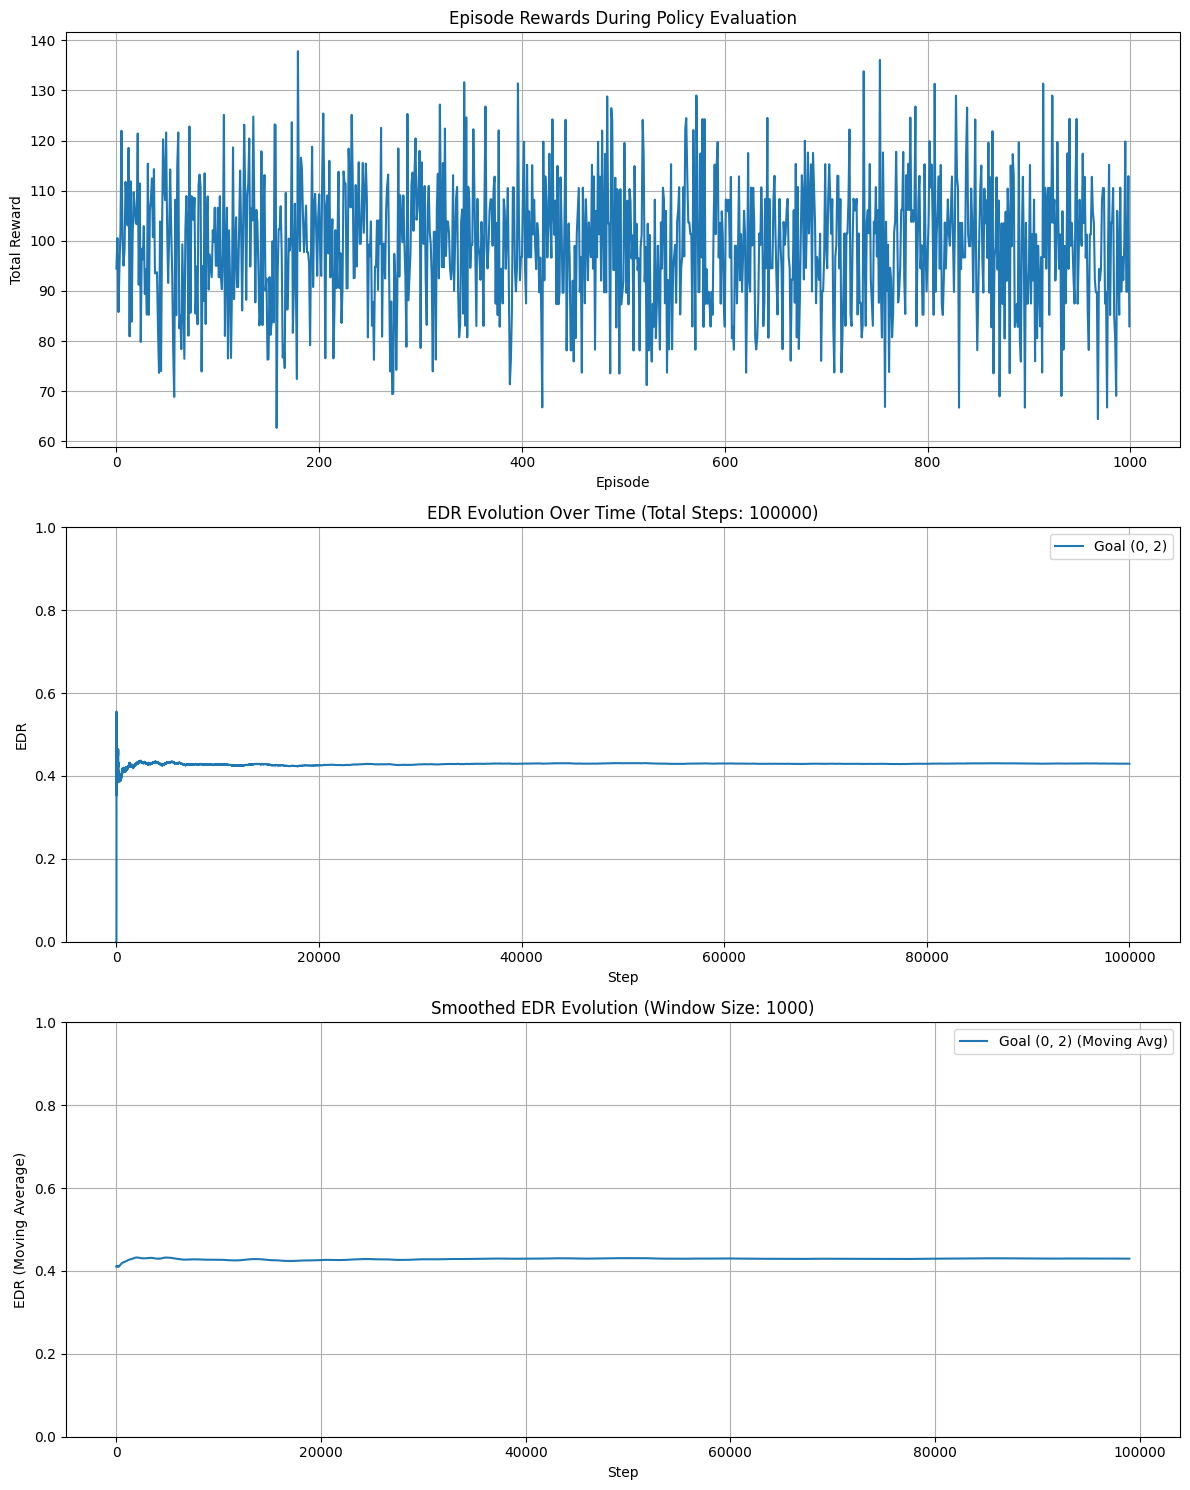


=== Policy Evaluation Results ===
Average Reward: 99.1606

Final EDRs:
Goal (0, 2): 0.429610
  - Successes: 42961.00
Total timesteps: 100000


In [18]:
# Create correct initial state format
initial_state = tuple((edge, -1) for edge in edges)

# Statistics tracking
goal_success_counts = defaultdict(float)
total_timesteps = 0
episode_rewards = []
edr_history = {goal: [] for goal in goalEdges}
instant_rates = {goal: pSwap ** (abs(goal[1] - goal[0]) - 1) for goal in goalEdges}

# Run multiple episodes
n_episodes = 1000
max_steps = 100

for episode in range(n_episodes):
    current_state = initial_state
    episode_reward = 0
    
    for step in range(max_steps):
        possible_transitions = all_transitions[current_state]
        policy_action = policy[current_state]
        valid_transitions = [
            (next_state, prob, achieved) 
            for next_state, prob, achieved in possible_transitions
            if achieved == policy_action
        ]
        
        if not valid_transitions:
            break
            
        # Evaluate each possible transition using current EDRs
        transition_values = []
        for next_state, prob, achieved_goals in valid_transitions:
            # Calculate the value of this transition using current EDRs
            if achieved_goals:
                value = 0
                for goal_edge, success in achieved_goals:
                    if success:
                        current_edr = max(0.0001, goal_success_counts[goal_edge] / max(1, total_timesteps))
                        instant_rate = instant_rates[goal_edge]
                        value += math.log(1 + instant_rate / current_edr)
                transition_values.append(value * prob)
            else:
                transition_values.append(0)
        
        # Choose transition based on current values
        normalized_values = np.array(transition_values)
        normalized_values = np.exp(normalized_values - np.max(normalized_values))  # numerical stability
        normalized_values = normalized_values / np.sum(normalized_values)
        
        # Select transition based on current values
        chosen_idx = np.random.choice(len(valid_transitions), p=normalized_values)
        next_state, prob, achieved_goals = valid_transitions[chosen_idx]
        
        # Update statistics
        total_timesteps += 1
        if achieved_goals:
            for goal_edge, success in achieved_goals:
                if success:
                    goal_success_counts[goal_edge] += 1
        
        # Track EDR history
        for goal in goalEdges:
            current_edr = goal_success_counts[goal] / total_timesteps
            edr_history[goal].append(current_edr)
        
        # Calculate reward using current EDRs
        reward = 0
        if achieved_goals:
            for goal_edge, success in achieved_goals:
                if success:
                    current_edr = max(0.0001, goal_success_counts[goal_edge] / max(1, total_timesteps))
                    instant_rate = instant_rates[goal_edge]
                    reward += instant_rate / current_edr
        
        episode_reward += reward
        current_state = next_state
    
    episode_rewards.append(episode_reward)

# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# Plot episode rewards
ax1.plot(episode_rewards)
ax1.set_title('Episode Rewards During Policy Evaluation')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.grid(True)

# Plot EDR evolution
for goal, edr_values in edr_history.items():
    ax2.plot(range(len(edr_values)), edr_values, label=f'Goal {goal}')
ax2.set_xlabel('Step')
ax2.set_ylabel('EDR')
ax2.set_title(f'EDR Evolution Over Time (Total Steps: {len(edr_history[goalEdges[0]])})')
ax2.grid(True)
ax2.legend()
ax2.set_ylim(0, 1)

# Plot moving average of EDRs
window_size = 1000  # Adjust this for smoother/rougher averaging
for goal in goalEdges:
    edr_values = edr_history[goal]
    moving_avg = np.convolve(edr_values, np.ones(window_size)/window_size, mode='valid')
    ax3.plot(range(len(moving_avg)), moving_avg, label=f'Goal {goal} (Moving Avg)')
ax3.set_xlabel('Step')
ax3.set_ylabel('EDR (Moving Average)')
ax3.set_title(f'Smoothed EDR Evolution (Window Size: {window_size})')
ax3.grid(True)
ax3.legend()
ax3.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print final statistics
print("\n=== Policy Evaluation Results ===")
print(f"Average Reward: {np.mean(episode_rewards):.4f}")
print("\nFinal EDRs:")
for goal in goalEdges:
    final_edr = goal_success_counts[goal] / total_timesteps
    print(f"Goal {goal}: {final_edr:.6f}")
    print(f"  - Successes: {goal_success_counts[goal]:.2f}")
print(f"Total timesteps: {total_timesteps}")